In [ ]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
DATA_ROOT = "drive/MyDrive/kaggle_data/Training"

CLASS_MAP = {
    "glioma": 0,
    "meningioma": 1,
    "pituitary": 2,
    "notumor": 3
}

print("Classes found:")
for cls in CLASS_MAP:
    print(f"- {cls}: {len(os.listdir(os.path.join(DATA_ROOT, cls)))} images")

Classes found:
- glioma: 1321 images
- meningioma: 1339 images
- pituitary: 1457 images
- notumor: 1595 images


Class: meningioma
Original shape: (512, 512)


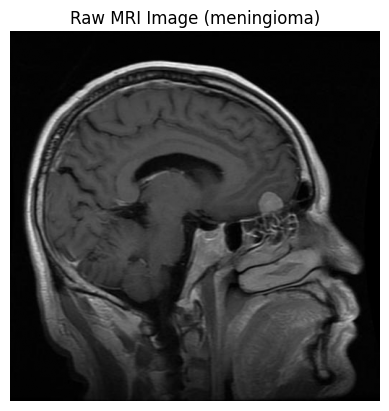

In [ ]:
cls = random.choice(list(CLASS_MAP.keys()))
img_name = random.choice(os.listdir(os.path.join(DATA_ROOT, cls)))
img_path = os.path.join(DATA_ROOT, cls, img_name)

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

print("Class:", cls)
print("Original shape:", img.shape)

plt.imshow(img, cmap="gray")
plt.title(f"Raw MRI Image ({cls})")
plt.axis("off")
plt.show()

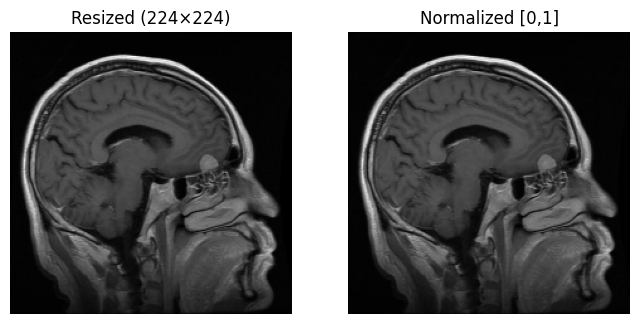

In [ ]:
IMG_SIZE = 224

img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img_norm = img_resized / 255.0

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(img_resized, cmap="gray")
plt.title("Resized (224×224)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_norm, cmap="gray")
plt.title("Normalized [0,1]")
plt.axis("off")

plt.show()

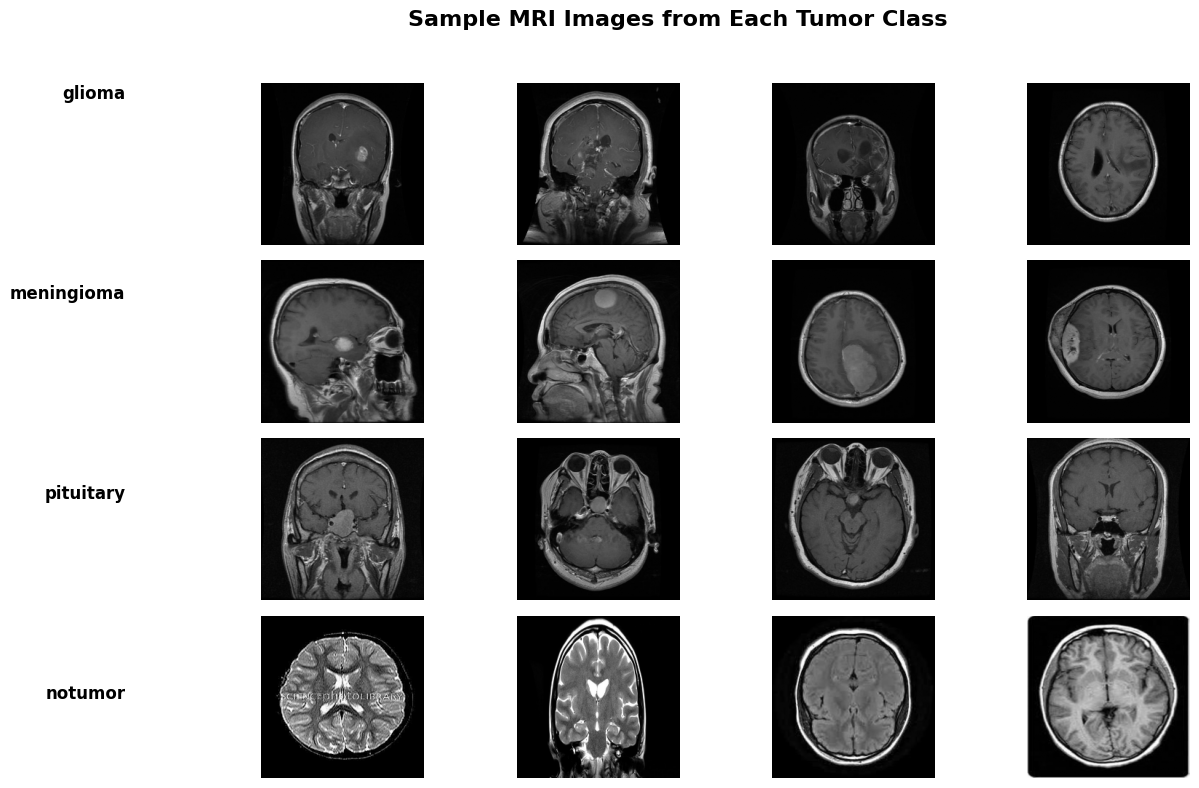

In [ ]:
def show_samples(root_dir, samples_per_class=4):
    classes = list(CLASS_MAP.keys())
    n_classes = len(classes)

    fig, axes = plt.subplots(
        n_classes,
        samples_per_class,
        figsize=(12, 8)
    )

    # Ensure axes is 2D
    if n_classes == 1:
        axes = axes[np.newaxis, :]
    if samples_per_class == 1:
        axes = axes[:, np.newaxis]

    for i, cls in enumerate(classes):
        cls_dir = os.path.join(root_dir, cls)
        images = random.sample(os.listdir(cls_dir), samples_per_class)

        for j, img_name in enumerate(images):
            img_path = os.path.join(cls_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (224, 224))

            axes[i, j].imshow(img, cmap="gray")
            axes[i, j].axis("off")


        fig.text(
            0.04,                          # x-position (left margin)
            1 - (i + 0.5) / n_classes,     # y-position (row center)
            cls,
            va="center",
            ha="right",
            fontsize=12,
            weight="bold"
        )

    plt.suptitle(
        "Sample MRI Images from Each Tumor Class",
        fontsize=16,
        weight="bold"
    )

    plt.tight_layout(rect=[0.08, 0, 1, 0.95])
    plt.show()


show_samples(DATA_ROOT, samples_per_class=4)

In [ ]:
all_shapes = []
all_pixels = []

for cls in CLASS_MAP:
    cls_dir = os.path.join(DATA_ROOT, cls)
    for img_name in random.sample(os.listdir(cls_dir), 20):
        img = cv2.imread(os.path.join(cls_dir, img_name), cv2.IMREAD_GRAYSCALE)
        all_shapes.append(img.shape)
        all_pixels.append(img.flatten())

all_pixels = np.concatenate(all_pixels)

print("Unique image shapes:", set(all_shapes))
print("Pixel intensity range:", all_pixels.min(), "to", all_pixels.max())

Unique image shapes: {(217, 232), (512, 416), (512, 512), (213, 236), (225, 225), (630, 630), (218, 180), (449, 359), (328, 267), (222, 227), (340, 339), (750, 750), (282, 230), (236, 236), (848, 785)}
Pixel intensity range: 0 to 255


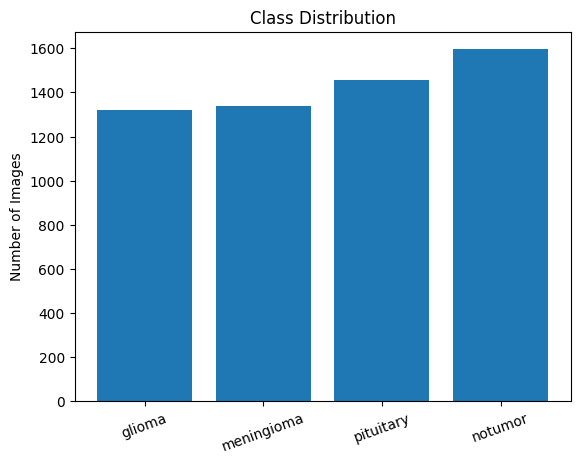

In [ ]:
class_counts = {cls: len(os.listdir(os.path.join(DATA_ROOT, cls))) for cls in CLASS_MAP}

plt.bar(class_counts.keys(), class_counts.values())
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.xticks(rotation=20)
plt.show()

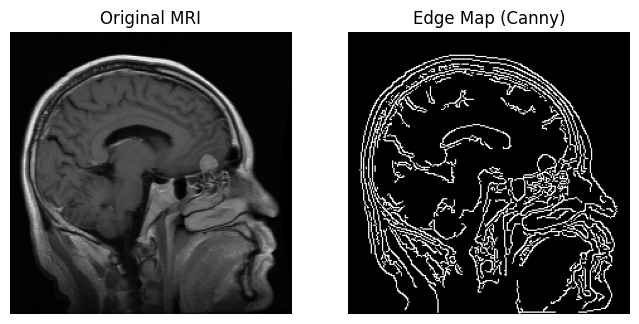

In [ ]:
edges = cv2.Canny((img_norm * 255).astype(np.uint8), 50, 150)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img_norm, cmap="gray")
plt.title("Original MRI")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(edges, cmap="gray")
plt.title("Edge Map (Canny)")
plt.axis("off")
plt.show()

In [ ]:
def extract_patches(img, grid=4):
    """
    img: 2D numpy array (H, W)
    returns: list of patches in row-wise order
    """
    h, w = img.shape
    ph, pw = h // grid, w // grid

    patches = []
    for i in range(grid):
        for j in range(grid):
            patch = img[i*ph:(i+1)*ph, j*pw:(j+1)*pw]
            patches.append(patch)

    return patches

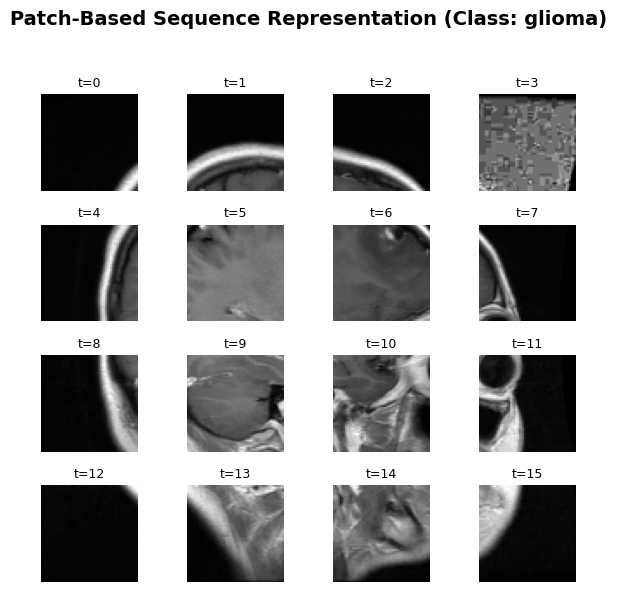

In [ ]:
# Load one example image
cls = "glioma"  # change class if you want
img_name = random.choice(os.listdir(os.path.join(DATA_ROOT, cls)))
img_path = os.path.join(DATA_ROOT, cls, img_name)

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (224, 224))
img = img / 255.0

patches = extract_patches(img, grid=4)

# Plot patch sequence
fig, axes = plt.subplots(4, 4, figsize=(6, 6))

idx = 0
for i in range(4):
    for j in range(4):
        axes[i, j].imshow(patches[idx], cmap="gray")
        axes[i, j].set_title(f"t={idx}", fontsize=9)
        axes[i, j].axis("off")
        idx += 1

plt.suptitle(
    f"Patch-Based Sequence Representation (Class: {cls})",
    fontsize=14,
    weight="bold"
)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load pretrained ResNet18
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Identity()   # remove classification head
resnet = resnet.to(DEVICE)
resnet.eval()

print("ResNet feature extractor ready")

ResNet feature extractor ready


In [ ]:
import torchvision.transforms as T
from PIL import Image

resnet_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

def preprocess_patch_for_resnet(patch):
    """
    patch: 2D numpy array (grayscale)
    returns: tensor (3, 224, 224)
    """
    patch = (patch * 255).astype("uint8")
    patch = Image.fromarray(patch)
    patch = patch.convert("RGB")
    return resnet_transform(patch)

In [ ]:
def extract_resnet_features_from_image(img, grid=4):
    patches = extract_patches(img, grid)
    patch_tensors = torch.stack(
        [preprocess_patch_for_resnet(p) for p in patches]
    ).to(DEVICE)

    with torch.no_grad():
        features = resnet(patch_tensors)

    return features.cpu().numpy()   # shape: (16, 512)

In [ ]:
cls = "glioma"
img_name = random.choice(os.listdir(os.path.join(DATA_ROOT, cls)))
img_path = os.path.join(DATA_ROOT, cls, img_name)

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (224, 224))
img = img / 255.0

features = extract_resnet_features_from_image(img)

print("Feature sequence shape:", features.shape)

Feature sequence shape: (16, 512)


In [ ]:
FEATURE_ROOT = "drive/MyDrive/kaggle_data/features"

for split in ["train", "test"]:
    for cls in CLASS_MAP:
        os.makedirs(os.path.join(FEATURE_ROOT, split, cls), exist_ok=True)

print("Feature directories created")

Feature directories created


In [ ]:
def extract_and_save_features(data_root, feature_root, split):
    for cls in CLASS_MAP:
        img_dir = os.path.join(data_root, cls)
        save_dir = os.path.join(feature_root, split, cls)

        for img_name in tqdm(os.listdir(img_dir), desc=f"{split}/{cls}"):
            img_path = os.path.join(img_dir, img_name)

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (224, 224))
            img = img / 255.0

            features = extract_resnet_features_from_image(img)  # (16, 512)

            save_path = os.path.join(
                save_dir,
                img_name.replace(".jpg", "").replace(".png", "") + ".npy"
            )

            np.save(save_path, features)

In [ ]:
from tqdm import tqdm

data_root_train = "drive/MyDrive/kaggle_data/Training"
data_root_test = "drive/MyDrive/kaggle_data/Testing"

extract_and_save_features(data_root_train, FEATURE_ROOT, "train")
extract_and_save_features(data_root_test, FEATURE_ROOT, "test")

test/notumor: 100%|██████████| 405/405 [00:28<00:00, 14.03it/s]


In [ ]:
sample_file = os.listdir("drive/MyDrive/kaggle_data/features/train/glioma")[0]
sample_feat = np.load(os.path.join("drive/MyDrive/kaggle_data/features/train/glioma", sample_file))

print("Loaded feature shape:", sample_feat.shape)

Loaded feature shape: (16, 512)


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
BASE_DIR = "/content/drive/MyDrive/kaggle_data"

TRAIN_FEATURES = os.path.join(BASE_DIR, "features/train")
TEST_FEATURES  = os.path.join(BASE_DIR, "features/test")

CLASS_MAP = {
    "glioma": 0,
    "meningioma": 1,
    "pituitary": 2,
    "notumor": 3
}
INV_CLASS_MAP = {v: k for k, v in CLASS_MAP.items()}

SEQ_LEN = 16        # number of patches
FEATURE_DIM = 512   # ResNet18 output
BATCH_SIZE = 32
EPOCHS = 25
LR = 1e-3

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

Device: cuda


In [ ]:
class FeatureDataset(Dataset):
    def __init__(self, feature_root):
        self.samples = []

        for cls, label in CLASS_MAP.items():
            cls_dir = os.path.join(feature_root, cls)
            for fname in os.listdir(cls_dir):
                self.samples.append(
                    (os.path.join(cls_dir, fname), label)
                )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        features = np.load(path)            # (16, 512)
        features = torch.tensor(features).float()
        return features, torch.tensor(label)

In [ ]:
train_ds = FeatureDataset(TRAIN_FEATURES)
x, y = train_ds[0]

print("Feature shape:", x.shape)
print("Label:", INV_CLASS_MAP[y.item()])

Feature shape: torch.Size([16, 512])
Label: glioma


In [ ]:
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_ds = FeatureDataset(TEST_FEATURES)
test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=FEATURE_DIM,
            hidden_size=256,
            num_layers=1,
            batch_first=True
        )
        self.fc = nn.Linear(256, len(CLASS_MAP))

    def forward(self, x):
        # x: (B, 16, 512)
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]   # last timestep
        return self.fc(out)

In [ ]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

In [ ]:
def evaluate(model, loader):
    model.eval()
    preds, trues = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            out = model(x)
            preds.extend(torch.argmax(out, dim=1).cpu().numpy())
            trues.extend(y.numpy())

    acc = accuracy_score(trues, preds)
    f1 = f1_score(trues, preds, average="macro")
    return acc, f1, trues, preds

In [ ]:
model = LSTMClassifier().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

for epoch in range(EPOCHS):
    loss = train_epoch(model, train_loader, optimizer, criterion)
    acc, f1, _, _ = evaluate(model, test_loader)

    print(
        f"Epoch {epoch+1:02d}/{EPOCHS} | "
        f"Loss: {loss:.4f} | "
        f"Test Acc: {acc:.4f} | "
        f"Macro F1: {f1:.4f}"
    )

Epoch 01/25 | Loss: 0.5382 | Test Acc: 0.8238 | Macro F1: 0.8079
Epoch 02/25 | Loss: 0.3004 | Test Acc: 0.8833 | Macro F1: 0.8796
Epoch 03/25 | Loss: 0.2473 | Test Acc: 0.8932 | Macro F1: 0.8895
Epoch 04/25 | Loss: 0.2085 | Test Acc: 0.9184 | Macro F1: 0.9136
Epoch 05/25 | Loss: 0.1478 | Test Acc: 0.9199 | Macro F1: 0.9161
Epoch 06/25 | Loss: 0.1275 | Test Acc: 0.9237 | Macro F1: 0.9193
Epoch 07/25 | Loss: 0.0894 | Test Acc: 0.9458 | Macro F1: 0.9415
Epoch 08/25 | Loss: 0.0756 | Test Acc: 0.9306 | Macro F1: 0.9266
Epoch 09/25 | Loss: 0.0628 | Test Acc: 0.9611 | Macro F1: 0.9591
Epoch 10/25 | Loss: 0.0454 | Test Acc: 0.9565 | Macro F1: 0.9533
Epoch 11/25 | Loss: 0.0402 | Test Acc: 0.9344 | Macro F1: 0.9322
Epoch 12/25 | Loss: 0.0229 | Test Acc: 0.9725 | Macro F1: 0.9704
Epoch 13/25 | Loss: 0.0226 | Test Acc: 0.9458 | Macro F1: 0.9417
Epoch 14/25 | Loss: 0.0257 | Test Acc: 0.9573 | Macro F1: 0.9539
Epoch 15/25 | Loss: 0.0136 | Test Acc: 0.9764 | Macro F1: 0.9744
Epoch 16/25 | Loss: 0.009

Final Accuracy: 0.9786422578184591
Final Macro F1: 0.9770942599922944


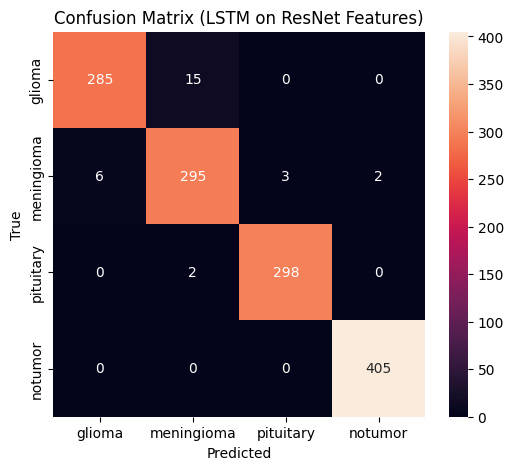

In [ ]:
acc, f1, y_true, y_pred = evaluate(model, test_loader)
print("Final Accuracy:", acc)
print("Final Macro F1:", f1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=CLASS_MAP.keys(),
    yticklabels=CLASS_MAP.keys()
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (LSTM on ResNet Features)")
plt.show()

In [ ]:
from sklearn.metrics import (
    classification_report,
    roc_curve,
    auc,
    precision_recall_fscore_support
)
from sklearn.preprocessing import label_binarize

In [ ]:
model.eval()

y_true = []
y_pred = []
y_prob = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE)
        outputs = model(x)                     # logits
        probs = torch.softmax(outputs, dim=1) # probabilities

        y_true.extend(y.numpy())
        y_pred.extend(torch.argmax(probs, dim=1).cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

print("Collected predictions:")
print("y_true shape:", y_true.shape)
print("y_prob shape:", y_prob.shape)

Collected predictions:
y_true shape: (1311,)
y_prob shape: (1311, 4)


In [ ]:
class_names = list(CLASS_MAP.keys())

print("Classification Report:\n")
print(
    classification_report(
        y_true,
        y_pred,
        target_names=class_names,
        digits=4
    )
)

Classification Report:

              precision    recall  f1-score   support

      glioma     0.9794    0.9500    0.9645       300
  meningioma     0.9455    0.9641    0.9547       306
   pituitary     0.9900    0.9933    0.9917       300
     notumor     0.9951    1.0000    0.9975       405

    accuracy                         0.9786      1311
   macro avg     0.9775    0.9768    0.9771      1311
weighted avg     0.9788    0.9786    0.9786      1311



In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true,
    y_pred,
    average=None
)

macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
    y_true,
    y_pred,
    average="macro"
)

weighted_p, weighted_r, weighted_f1, _ = precision_recall_fscore_support(
    y_true,
    y_pred,
    average="weighted"
)

for i, cls in enumerate(class_names):
    print(f"{cls:12s} | Precision: {precision[i]:.4f} | Recall: {recall[i]:.4f} | F1: {f1[i]:.4f}")

print("\nMacro Avg  | Precision:", round(macro_p,4),
      "| Recall:", round(macro_r,4),
      "| F1:", round(macro_f1,4))

print("Weighted  | Precision:", round(weighted_p,4),
      "| Recall:", round(weighted_r,4),
      "| F1:", round(weighted_f1,4))

glioma       | Precision: 0.9794 | Recall: 0.9500 | F1: 0.9645
meningioma   | Precision: 0.9455 | Recall: 0.9641 | F1: 0.9547
pituitary    | Precision: 0.9900 | Recall: 0.9933 | F1: 0.9917
notumor      | Precision: 0.9951 | Recall: 1.0000 | F1: 0.9975

Macro Avg  | Precision: 0.9775 | Recall: 0.9768 | F1: 0.9771
Weighted  | Precision: 0.9788 | Recall: 0.9786 | F1: 0.9786


In [ ]:
n_classes = len(CLASS_MAP)

y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

In [ ]:
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

macro_auc = auc(all_fpr, mean_tpr)

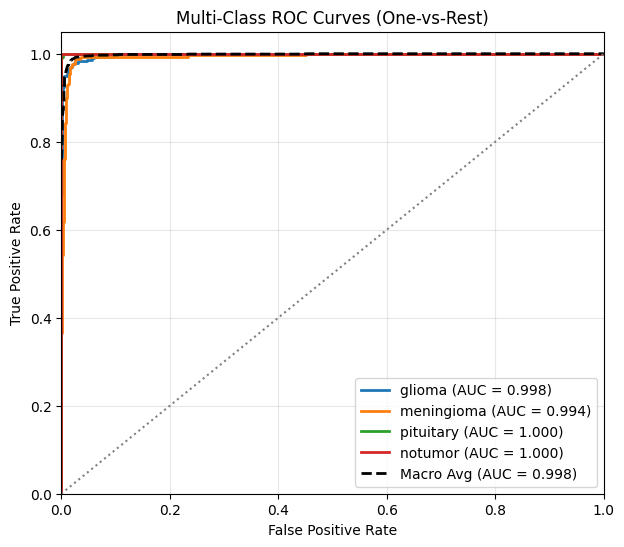

In [ ]:
plt.figure(figsize=(7, 6))

for i, cls in enumerate(class_names):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=2,
        label=f"{cls} (AUC = {roc_auc[i]:.3f})"
    )

plt.plot(
    all_fpr,
    mean_tpr,
    linestyle="--",
    color="black",
    label=f"Macro Avg (AUC = {macro_auc:.3f})",
    lw=2
)

plt.plot([0, 1], [0, 1], linestyle=":", color="gray")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
print("AUC per class:")
for i, cls in enumerate(class_names):
    print(f"{cls:12s}: {roc_auc[i]:.4f}")

print("\nMacro-average AUC:", round(macro_auc, 4))

AUC per class:
glioma      : 0.9976
meningioma  : 0.9939
pituitary   : 1.0000
notumor     : 1.0000

Macro-average AUC: 0.9979


In [ ]:
SAVE_DIR = "/content/drive/MyDrive/brain_tumor_project/models"
os.makedirs(SAVE_DIR, exist_ok=True)

model_path = os.path.join(SAVE_DIR, "lstm_classifier.pth")

torch.save({
    "model_state_dict": model.state_dict(),
    "class_map": CLASS_MAP,
    "seq_len": SEQ_LEN,
    "feature_dim": FEATURE_DIM
}, model_path)

print("LSTM model saved to:", model_path)

LSTM model saved to: /content/drive/MyDrive/brain_tumor_project/models/lstm_classifier.pth
